## Fermi Data

Visualizing the galactic center excess data from Fermi-LAT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def results_plots(data, generated=None, save_dir=None, features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'], num_particles=None):
    num_particles = 100000000 if num_particles is None else num_particles
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])
    gs.update(hspace=0.1) 
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        h1, bins, _ = ax.hist(data[..., idx].flatten()[:num_particles], bins=100, color='silver', density=True)
        if generated is not None:
            h2, _, _ = ax.hist(generated[..., idx].flatten()[:num_particles], bins=100, color=['gold', 'darkblue', 'darkred'][idx], histtype='step', density=True, lw=0.75)
            ax.set_xticklabels([])
            ax.set_xticks([])
            for tick in ax.yaxis.get_major_ticks():
               tick.label.set_fontsize(8)
        else:
            ax.set_xlabel(feature)
        
        # Ratio plot
        if generated is not None:
            ax_ratio = fig.add_subplot(gs[idx + 3])
            ratio = np.divide(h1, h2, out=np.ones_like(h2), where=h2 != 0)
            ax_ratio.plot(0.5 * (bins[:-1] + bins[1:]), ratio, color=['gold', 'darkblue', 'darkred'][idx],lw=0.75)
            ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
            ax_ratio.set_xlabel(feature)
            ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
            for tick in ax_ratio.xaxis.get_major_ticks():
               tick.label.set_fontsize(7)
            for tick in ax_ratio.yaxis.get_major_ticks():
              tick.label.set_fontsize(5)  
            if idx == 0:
                ax_ratio.set_ylabel('ratio', fontsize=8)
            ax_ratio.set_yticks([0.5, 1, 1.5])
    if save_dir is not None:
        plt.savefig(save_dir + '/fermi_features.pdf')
    plt.show()


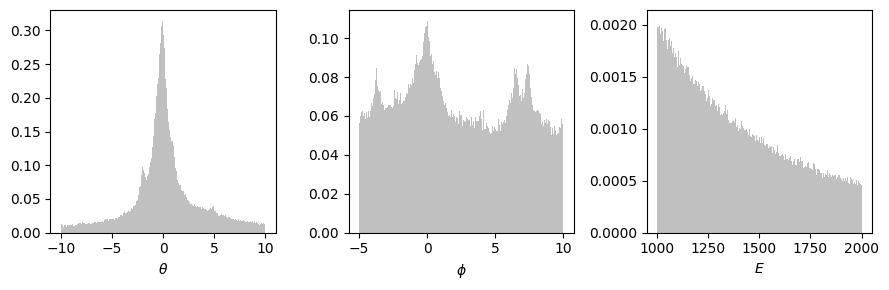

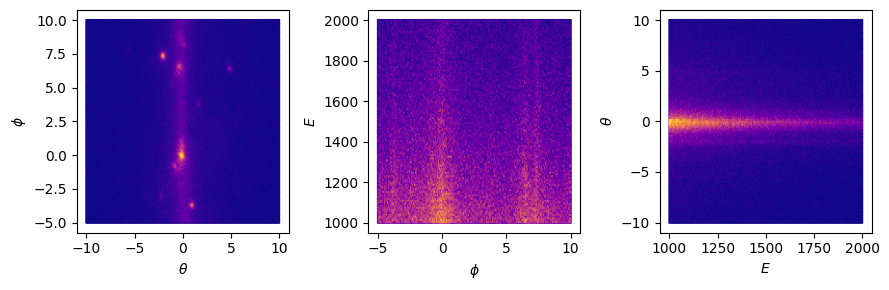

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from DynGenModels.datamodules.fermi.datasets import FermiDataset
from DynGenModels.datamodules.fermi.configs import FermiGCE_Configs 

configs = FermiGCE_Configs(cuts = {'theta': [-10., 10.], 'phi': [-5., 10.], 'energy': [1000, 2000]})
fermi = FermiDataset(configs)

#...plot data:

coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(fermi.target[..., i], bins=500, color='silver', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(fermi.target[..., i], fermi.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

## Flow-Matching
We train a CNF with Flow-matching (Lipman et al. 2023) with a simple MLP architecture

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_MLP_FlowMatch as Configs

configs = Configs(dataset = '../../data/fermi/fermi_data_galactic_coord.npy',
                  features = ['theta', 'phi', 'energy'],
                  preprocess=['normalize', 'logit_transform', 'standardize'], 
                  cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                  data_split_fracs = [0.8, 0.2, 0.0],
                  EPOCHS = 200,
                  batch_size = 10000,
                  lr = 1e-4,
                  dim_hidden = 64, 
                  num_layers = 3,
                  sigma = 0.0,
                  solver='midpoint',
                  num_sampling_steps=200)

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define setup and train model :

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.flowmatch import FlowMatching

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = MLP(configs)
dynamics = FlowMatching(net, configs)
fm = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
fm.train()

#==============================================================================
INFO: created directory: ../../results/FermiGCE.FlowMatch.MLP.2023.10.11_21h19
#==============================================================================
+--------------------+-------------------------------------------------+
| Parameters         | Values                                          |
+--------------------+-------------------------------------------------+
| DATA               | FermiGCE                                        |
| dataset            | ../../data/fermi/fermi_data_galactic_coord.npy  |
| features           | ['theta', 'phi', 'energy']                      |
| dim_input          | 3                                               |
| preprocess         | ['normalize', 'logit_transform', 'standardize'] |
| cuts               | theta: [-10.0, 10.0]                            |
|                    | phi: [4.0, 10.0]                                |
|                    | energy: 

epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Sample from trained FM model:

In [25]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData 

pipeline = FlowMatchPipeline(trained_model=fm, 
                             source_input=torch.randn(100000, 3),
                             configs=configs, 
                             postprocessor=PostProcessFermiData)

INFO: neural ODE solver with midpoint method and steps=200


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:19: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:28: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:32: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

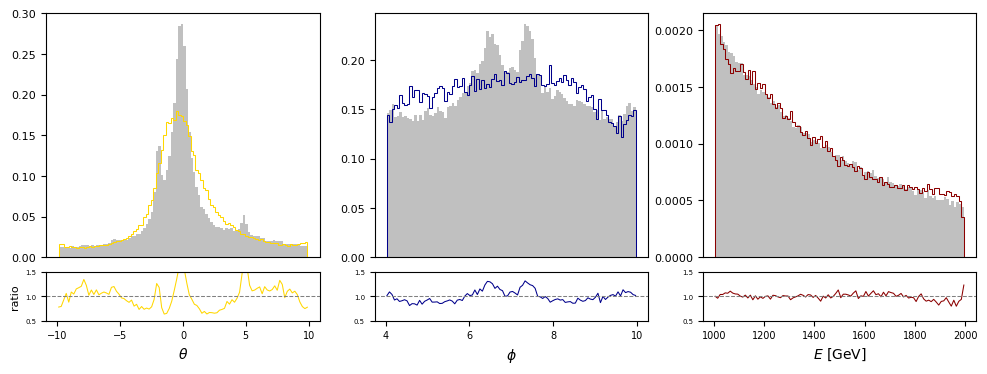

In [27]:
results_plots(fermi.target, generated=pipeline.target, save_dir=None, features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

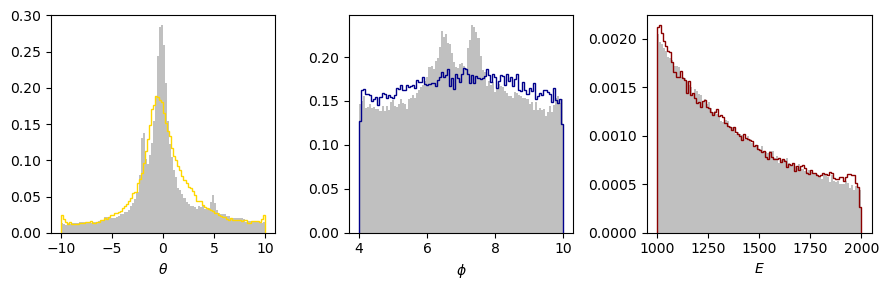

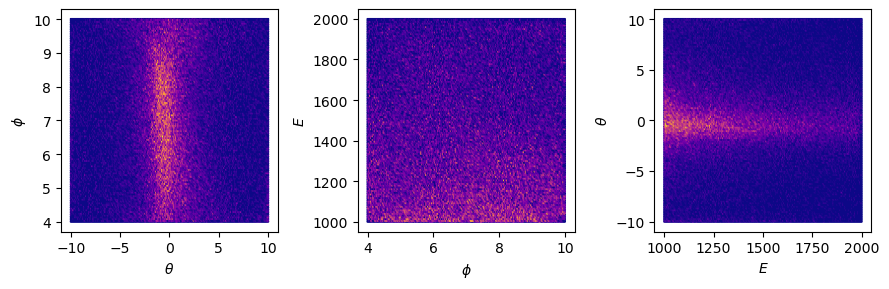

In [26]:
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(fermi .target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pipeline.target[..., i], pipeline.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

## Conditional Flow-Matching
We train a Simplified Conditional Flow-matching (Tong et al. 2023) with a MLP and ResNet architectures.

### MLP architecture

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_MLP_CondFlowMatch as Configs

configs = Configs(datset = '../../data/fermi/fermi_data_galactic_coord.npy',
                  features = ['theta', 'phi', 'energy'],
                  preprocess=['normalize', 'logit_transform', 'standardize'], 
                  cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                  data_split_fracs = [0.8, 0.2, 0.0],
                  EPOCHS = 200,
                  batch_size = 10000,
                  lr = 1e-4,
                  dim_hidden = 64, 
                  num_layers = 3,
                  sigma = 0.0,
                  solver='midpoint',
                  num_sampling_steps=200)

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define setup and train model :

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.flowmatch import SimplifiedCondFlowMatching

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = MLP(configs)
dynamics = SimplifiedCondFlowMatching(net, configs)
cfm = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
cfm.train()


#===============================================================================
INFO: created directory: ../results/FermiGCE.CondFlowMatch.MLP.2023.10.05_16h22
#===============================================================================
+--------------------+-------------------------------------------------+
| Parameters         | Values                                          |
+--------------------+-------------------------------------------------+
| data_name          | FermiGCE                                        |
| dataset            | ../data/fermi/fermi_data_galactic_coord.npy     |
| features           | ['theta', 'phi', 'energy']                      |
| dim_input          | 3                                               |
| preprocess         | ['normalize', 'logit_transform', 'standardize'] |
| cuts               | theta: [-10.0, 10.0]                            |
|                    | phi: [4.0, 10.0]                                |
|                    | energ

epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Sample from trained model:

In [10]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(100000, 3),
                             configs=configs, 
                             postprocessor=PostProcessFermiData)

INFO: neural ODE solver with midpoint method and steps=200
INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


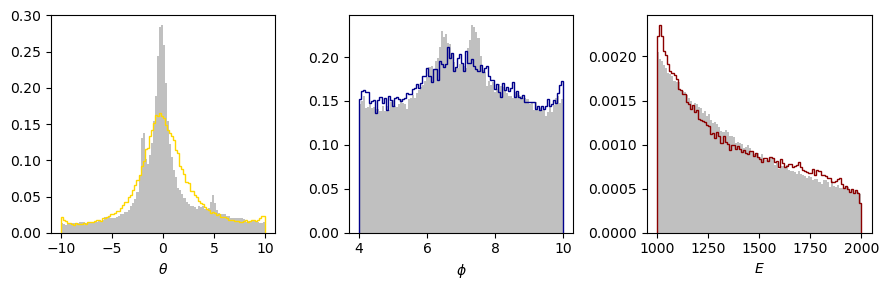

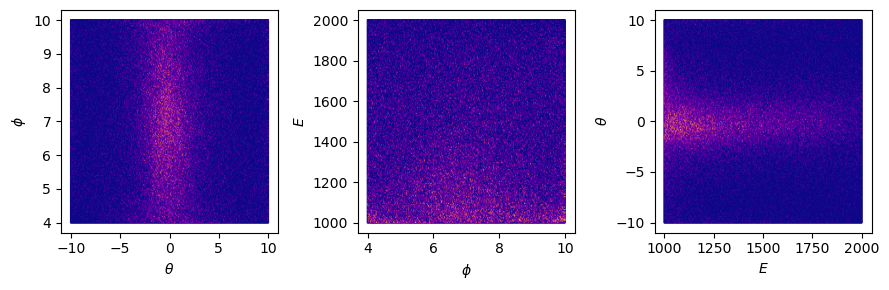

In [13]:
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(fermi .target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pipeline.target[..., i], pipeline.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

### ResNet architecture

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_ResNet_CondFlowMatch as Configs

configs = Configs(dataset = '../../data/fermi/fermi_data_galactic_coord.npy',
                  features = ['theta', 'phi', 'energy'],
                  preprocess=['normalize', 'logit_transform', 'standardize'], 
                  cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                  data_split_fracs = [0.8, 0.2, 0.0],
                  EPOCHS = 100,
                  batch_size = 10000,
                  lr = 5e-4,
                  dim_hidden = 128, 
                  num_blocks = 5,
                  num_block_layers = 3,
                  sigma = 0.0,
                  solver='midpoint',
                  num_sampling_steps=200)

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define setup and train model:

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.deep_nets import ResNet
from DynGenModels.dynamics.cnf.flowmatch import SimplifiedCondFlowMatching

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = ResNet(configs)
dynamics = SimplifiedCondFlowMatching(net, configs)
cfm = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
cfm.train()


#==================================================================================
INFO: created directory: ../results/FermiGCE.CondFlowMatch.ResNet.2023.10.05_16h34
#==================================================================================
+--------------------+-------------------------------------------------+
| Parameters         | Values                                          |
+--------------------+-------------------------------------------------+
| data_name          | FermiGCE                                        |
| dataset            | ../data/fermi/fermi_data_galactic_coord.npy     |
| features           | ['theta', 'phi', 'energy']                      |
| dim_input          | 3                                               |
| preprocess         | ['normalize', 'logit_transform', 'standardize'] |
| cuts               | theta: [-10.0, 10.0]                            |
|                    | phi: [4.0, 10.0]                                |
|                  

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Sample from trained model:

In [22]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(100000, 3),
                             configs=configs, 
                             postprocessor=PostProcessFermiData)

INFO: neural ODE solver with midpoint method and steps=200


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


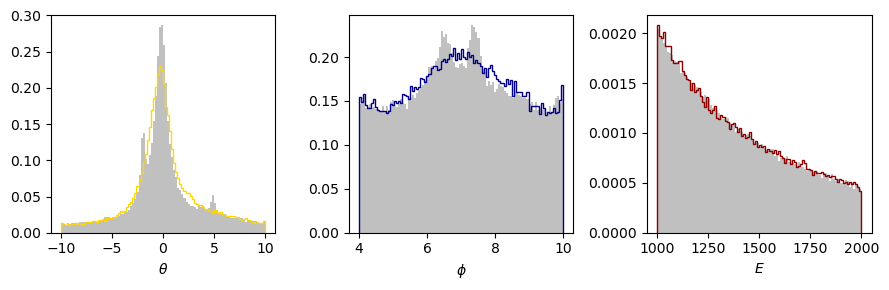

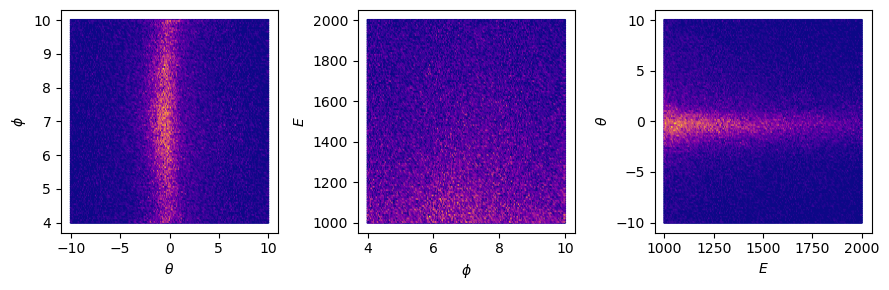

In [23]:
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(fermi .target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pipeline.target[..., i], pipeline.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

# Normalizing flows 
We train a good old MAF and coupling layers with rational quadratic spline transforms

### MAF

In [1]:
import matplotlib.pyplot as plt

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_MAF_RQS_NormFlow as Configs


configs = Configs(dataset = '../../data/fermi/fermi_data_galactic_coord.npy',
                features = ['theta', 'phi', 'energy'],
                preprocess = ['normalize', 'logit_transform', 'standardize'],
                cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                data_split_fracs = [0.8, 0.2, 0.0],
                EPOCHS = 10,
                batch_size = 10000,
                lr = 1e-4,
                dim_hidden = 256, 
                DEVICE = 'cpu',
                seed = 12345,
                num_transforms = 5,
                num_blocks = 2,
                dr
                num_gen_samples = 100000
                )

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define dataset :

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = MAFPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
maf = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
maf.train()

#=================================================================================
INFO: created directory: ../../results/FermiGCE.NormFlow.MAF_RQS.2023.10.11_22h31
#=================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE                                        |
| dataset             | ../../data/fermi/fermi_data_galactic_coord.npy  |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [-10.0, 10.0]                            |
|                     | phi: [4.0, 10.0]                                |
|           

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [2]:
#...sample from model
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline = NormFlowPipeline(trained_model=maf, 
                            configs=configs, 
                            postprocessor=PostProcessFermiData,
                            best_epoch_model=True,
                            num_gen_samples=100000)

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_30552/1180423315.py:19: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_30552/1180423315.py:28: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_30552/1180423315.py:32: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_30552/1180423315.py:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

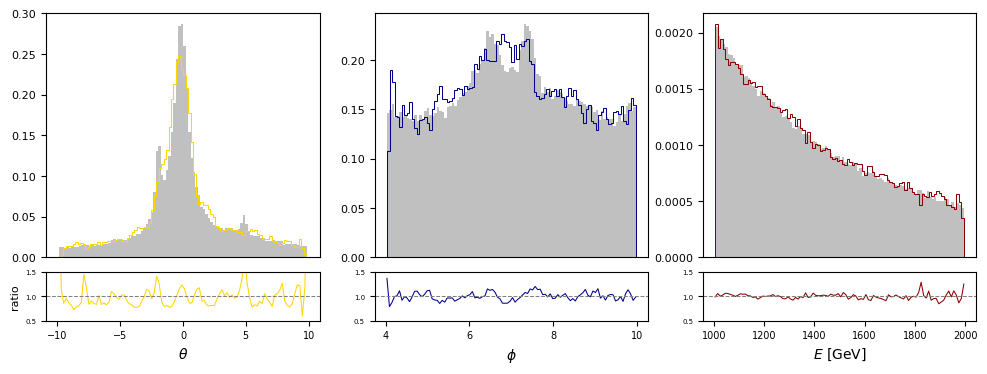

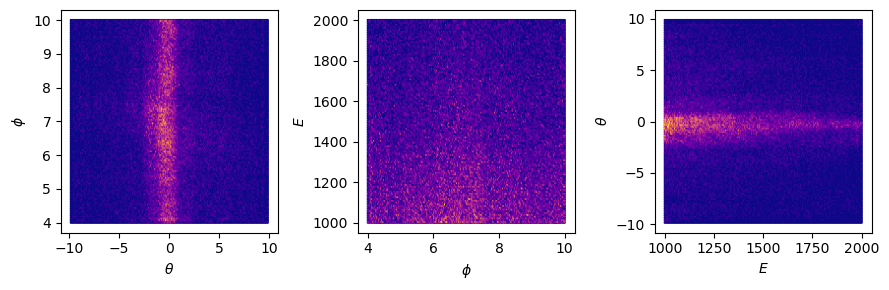

In [5]:
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']

results_plots(fermi.target, generated=pipeline.target, save_dir=configs.workdir, features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pipeline.target[..., i], pipeline.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.savefig(configs.workdir + '/fermi_features_2D.pdf')
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def results_plots(data, generated=None, save_dir=None, features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'], num_particles=None):
    num_particles = 100000000 if num_particles is None else num_particles
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(2, 3, height_ratios=[5, 1])
    gs.update(hspace=0.1) 
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        h1, bins, _ = ax.hist(data[..., idx].flatten()[:num_particles], bins=100, color='silver', density=True)
        if generated is not None:
            h2, _, _ = ax.hist(generated[..., idx].flatten()[:num_particles], bins=100, color=['gold', 'darkblue', 'darkred'][idx], histtype='step', density=True, lw=0.75)
            ax.set_xticklabels([])
            ax.set_xticks([])
            for tick in ax.yaxis.get_major_ticks():
               tick.label.set_fontsize(8)
        else:
            ax.set_xlabel(feature)
        
        # Ratio plot
        if generated is not None:
            ax_ratio = fig.add_subplot(gs[idx + 3])
            ratio = np.divide(h1, h2, out=np.ones_like(h2), where=h2 != 0)
            ax_ratio.plot(0.5 * (bins[:-1] + bins[1:]), ratio, color=['gold', 'darkblue', 'darkred'][idx],lw=0.75)
            ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
            ax_ratio.set_xlabel(feature)
            ax_ratio.axhline(1, color='gray', linestyle='--', lw=0.75)
            for tick in ax_ratio.xaxis.get_major_ticks():
               tick.label.set_fontsize(7)
            for tick in ax_ratio.yaxis.get_major_ticks():
              tick.label.set_fontsize(5)  
            if idx == 0:
                ax_ratio.set_ylabel('ratio', fontsize=8)
            ax_ratio.set_yticks([0.5, 1, 1.5])
    if save_dir is not None:
        plt.savefig(save_dir + '/fermi_features.pdf')
    plt.show()


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:19: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(8)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:28: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.5, 1.5, 0) # Adjust this as needed
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:32: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(7)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_22856/1180423315.py:34: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be remo

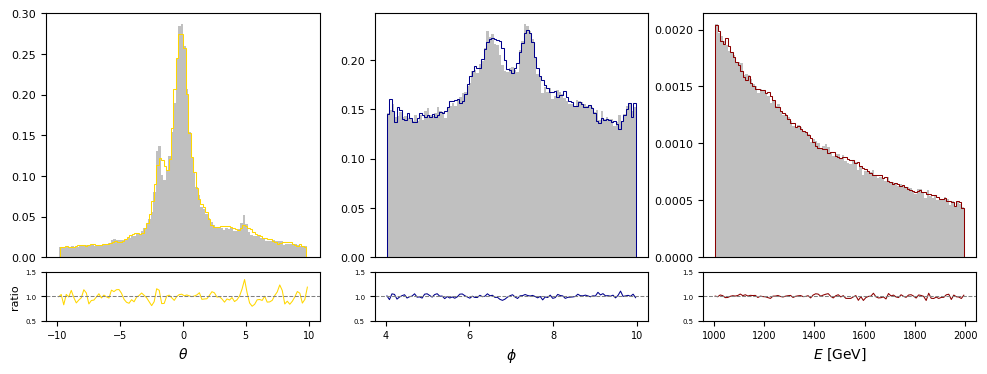

In [23]:
results_plots(fermi.target, generated=pipeline.target, save_dir=None, features=[r'$\theta$', r'$\phi$', r'$E$ [GeV]'])

### Coupling Layers

In [4]:
import matplotlib.pyplot as plt

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_Couplings_RQS_NormFlow as Configs


configs = Configs(dataset = '../../data/fermi/fermi_data_galactic_coord.npy',
                features = ['theta', 'phi', 'energy'],
                preprocess = ['normalize', 'logit_transform', 'standardize'],
                cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                data_split_fracs = [0.8, 0.2, 0.0],
                EPOCHS = 10,
                batch_size = 10000,
                lr = 1e-4,
                dim_hidden = 256, 
                seed = 12345,
                mask = 'checkerboard',
                num_transforms = 5,
                num_gen_samples =100000
                )

#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define dataset :

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import CouplingsPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow

fermi = FermiDataset(configs)
dataloader = FermiDataLoader(fermi, configs)
net = CouplingsPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
coupl = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
coupl.train()

#=======================================================================================
INFO: created directory: ../../results/FermiGCE.NormFlow.Couplings_RQS.2023.10.11_20h41
#=======================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE                                        |
| dataset             | ../../data/fermi/fermi_data_galactic_coord.npy  |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [-10.0, 10.0]                            |
|                     | phi: [4.0, 10.0]                            

epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
#...sample from model
from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline = NormFlowPipeline(trained_model=coupl, 
                            configs=configs, 
                            postprocessor=PostProcessFermiData)

INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


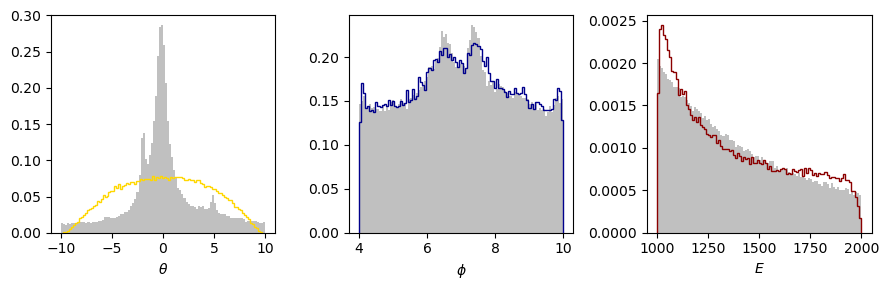

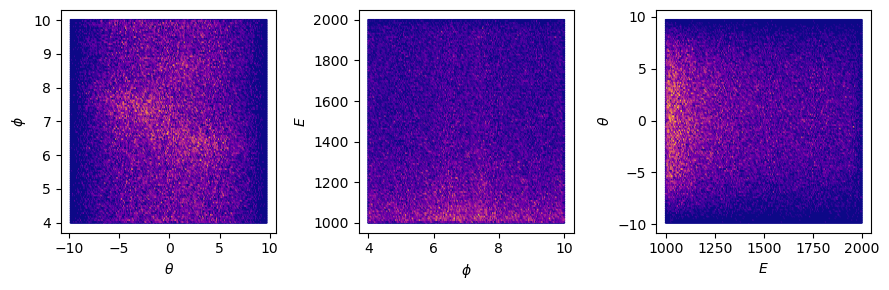

In [6]:
coord = [r'$\theta$', r'$\phi$', r'$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(fermi .target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].hexbin(pipeline.target[..., i], pipeline.target[..., j], cmap='plasma', gridsize=200)
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()